# Huaiyuan Fan Machine Learning & Predictive Analysis Final Project

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

 Choose a real-world machine learning problem with an objective
• Procure and analyze the data
• Develop at a deep learning or recommender system model
• Outline data / model assumptions & limitations / hypotheses
• Evaluate model metrics such as overfitting / underfitting
• Select final model based on selection criteria
• Determine how the model can be improved
• Effectively communicate analytical work
For the class project, students are graded on 8 criteria outlined below. Each criterion is 5 points for a
total of 40 points. The criteria are:
1. Problem Statement
2. Assumptions/Hypotheses about daProblem Statementta and model
3. Exploratory Data Analysis
4. Feature Engineering & Transformations
5. Proposed Approaches (Model) with checks for overfitting/underfitting
6. Proposed Solution (Model Selection) with regularization, if needed
7. Results (Accuracy) and Learnings from the methodology
8. Future Work

# 1.Problem Statement

# 2. Assumption

### *Looking at the distribution of the dataset, the largest class contains about 2000 images and the smallest class contains only about 200, this means the dataset is extremely imbalanced. Indicate that perturbation is needed to create balanced images in each class.**
### **Also by looking at the images in each class, each class only contains up to 5 unique images per class and rest of the images are pre-augumented images.*

# 3.EDA

In [2]:
train_datagen = ImageDataGenerator()

In [3]:
train_generator = train_datagen.flow_from_directory(
    'Train',
    target_size=(64, 64),
    class_mode='categorical', 
    batch_size=32)

Found 39209 images belonging to 43 classes.


### *Using the Train_generatror, we know that the original dataset contains 43 classes and 39,209 images in total.*

## 3. 1）Visualize to see the distribution of class

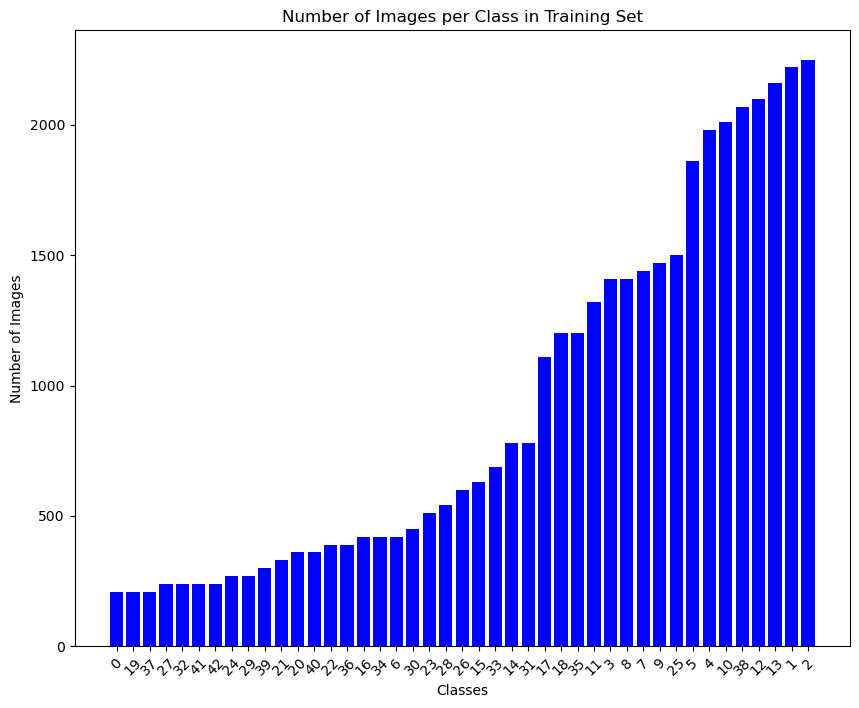

In [4]:
train_folder_path = 'train'

class_counts = {}


for class_folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, class_folder)
    if os.path.isdir(folder_path):  
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        class_counts[class_folder] = num_files

sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1])


sorted_classes, sorted_counts = zip(*sorted_class_counts)

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.bar(sorted_classes, sorted_counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.xticks(rotation=45)
plt.show()


#### *Looking at the distribution of the dataset, the largest class contains about 2000 images and the smallest class contains only about 200, this means the dataset is extremely imbalanced. Indicate that perturbation is needed to create balanced images in each class.*

## 3. 2）Average Class Size

In [5]:
average_images_per_class = sum(class_counts.values()) / len(class_counts)
average_images_per_class

911.8372093023256

## 3. 3）Summary Statistics

In [6]:
train_folder_path = 'Train'
image_data = []

# Collect image data
for class_folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, class_folder)
    if os.path.isdir(folder_path):
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            if os.path.isfile(image_path):
                with Image.open(image_path) as img:
                    width, height = img.size
                    aspect_ratio = width / height
                    image_data.append((class_folder, width, height, aspect_ratio))

In [7]:
df = pd.DataFrame(image_data, columns=['class', 'width', 'height', 'aspect_ratio'])

summary = df.groupby('class').agg({
    'width': ['mean', 'std'],
    'height': ['mean', 'std'],
    'aspect_ratio': ['mean', 'std'],
    'class': 'count'
}).reset_index()

summary.columns = ['class', 'width_mean', 'width_std', 'height_mean', 'height_std', 'aspect_ratio_mean', 'aspect_ratio_std', 'count']
summary


,class,width_mean,width_std,height_mean,height_std,aspect_ratio_mean,aspect_ratio_std,count
0,0,52.909524,23.101739,53.857143,24.138131,0.988341,0.040784,210
1,1,52.484685,21.730046,53.500901,22.276146,0.983079,0.049041,2220
2,10,43.341791,15.421959,42.921393,15.293797,1.011203,0.055131,2010
3,11,64.037879,32.516819,59.714394,28.510021,1.062297,0.085320,1320
4,12,54.128095,24.795500,54.422381,24.619528,0.994801,0.057920,2100
5,13,60.235648,28.667869,56.853704,25.935268,1.057081,0.095265,2160
6,14,64.425641,32.710083,66.434615,33.287360,0.970785,0.053898,780
7,15,46.406349,19.460611,51.607937,24.503728,0.922789,0.117620,630
8,16,53.871429,28.273935,54.371429,27.875364,0.987608,0.030390,420
9,17,38.010811,12.198681,40.273874,12.464367,0.944764,0.076644,1110


## 3. 4）Pixel Size Distributions

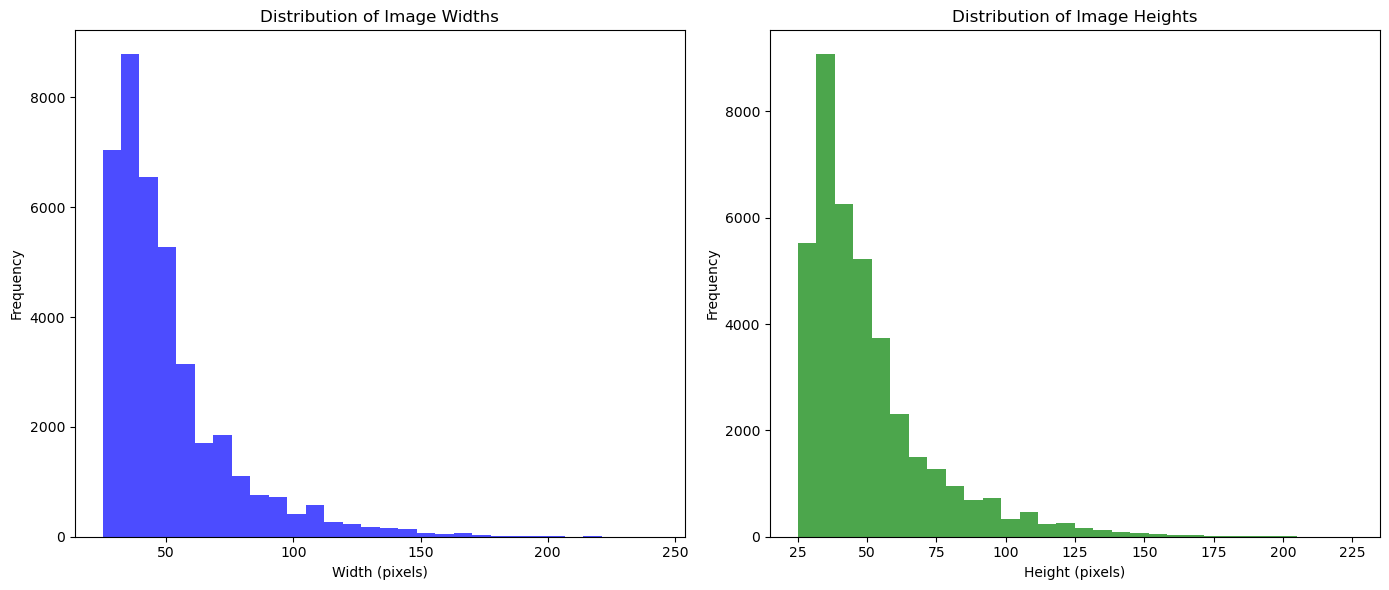

In [8]:
# Plot pixel size distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df['width'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Widths')

plt.subplot(1, 2, 2)
plt.hist(df['height'], bins=30, color='green', alpha=0.7)
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights')

plt.tight_layout()
plt.show()

## 3. 5）Aspect Ratio Distribution

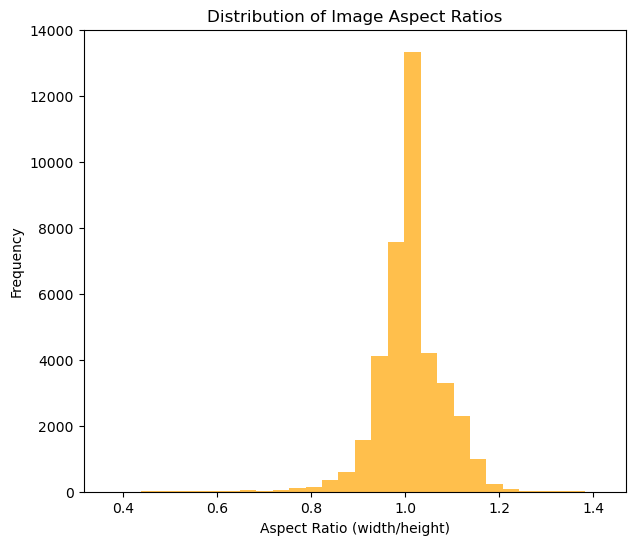

In [9]:
# Plot aspect ratio distribution
plt.figure(figsize=(7, 6))
plt.hist(df['aspect_ratio'], bins=30, color='orange', alpha=0.7)
plt.xlabel('Aspect Ratio (width/height)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Aspect Ratios')
plt.show()

## 3. 6） return some sample pictures, size of 10

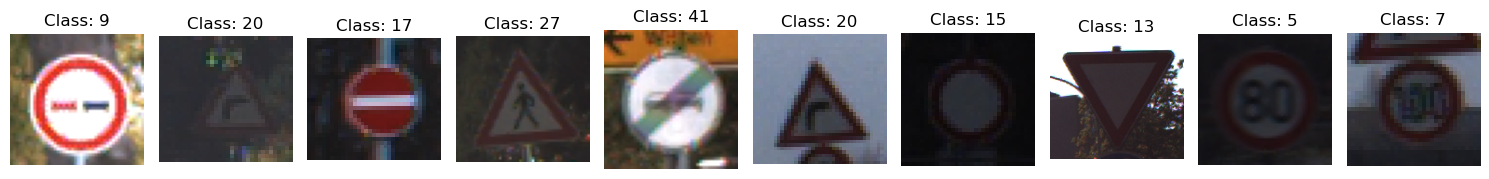

In [10]:
train_folder_path = 'train'
num_images_total = 10
all_images = []


for class_folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, class_folder)
    if os.path.isdir(folder_path): 

        image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        all_images.extend([(class_folder, img) for img in image_files])

random_images = random.sample(all_images, min(num_images_total, len(all_images)))

fig, axs = plt.subplots(1, len(random_images), figsize=(15, 5))

if num_images_total == 1:
    axs = [axs]

for idx, (class_name, img_path) in enumerate(random_images):
    img = Image.open(img_path)
    axs[idx].imshow(img)
    axs[idx].axis('off')  # Hide the axis
    axs[idx].set_title(f"Class: {class_name}")

plt.tight_layout()
plt.show()


# 4.Feature Engineering & Transformations

## 4. 1）There are too many classes so reduction to 15 classes is made

In [11]:
# Define the path to the training folder
train_folder_path = 'train'

# Define the classes to keep
classes_to_keep = set(str(i) for i in range(15))

# Iterate over the class folders in the training directory
for class_folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, class_folder)
    if os.path.isdir(folder_path) and class_folder not in classes_to_keep:
        # Remove the folder if it's not in the classes to keep
        shutil.rmtree(folder_path)

print(f"Reduced the number of classes to 14. Kept classes: {sorted(classes_to_keep)}")


Reduced the number of classes to 14. Kept classes: ['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


## *Looking at the oringal data, it came to the realization that the actual trainset only contains limited amount of unique images, so I went online and found 30 unique images for each class and now the train set has more varieties of images*
## *From this point, operations and model will be build on top of the new dataset*

## Since new dataset is created, EDA will be done on new dataset

# New EDA

## New EDA. 1）Visualize to see the distribution of class

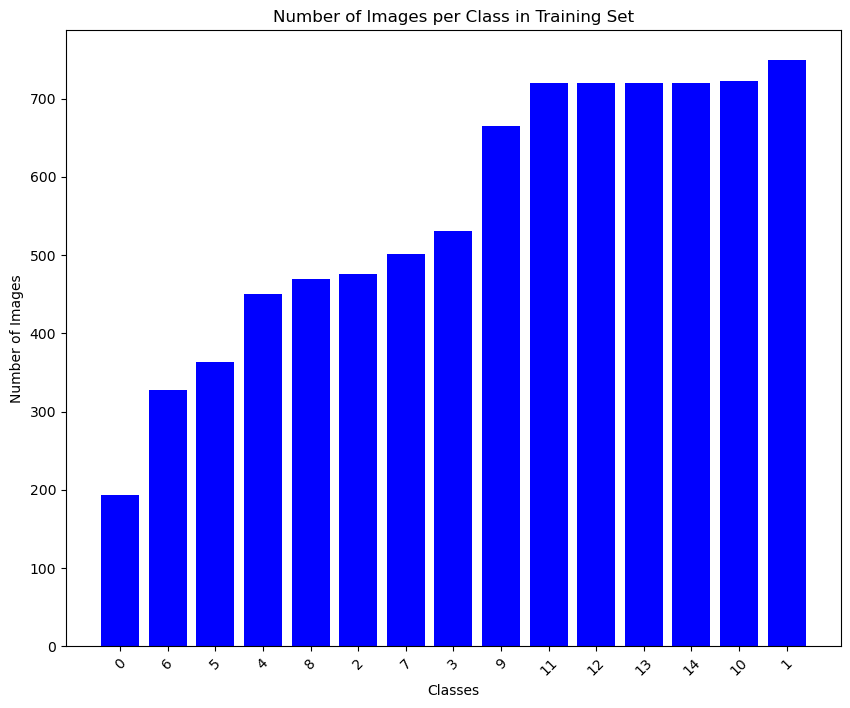

In [12]:
train_folder_path = 'Train'

class_counts = {}


for class_folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, class_folder)
    if os.path.isdir(folder_path):  
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        class_counts[class_folder] = num_files

sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1])


sorted_classes, sorted_counts = zip(*sorted_class_counts)

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.bar(sorted_classes, sorted_counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.xticks(rotation=45)
plt.show()


## New EDA. 2）Average Class Size

In [13]:
average_images_per_class = sum(class_counts.values()) / len(class_counts)
average_images_per_class

555.4

## New EDA. 3）Summary Statistics

In [14]:
train_folder_path = 'Train'
image_data = []

# Collect image data
for class_folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, class_folder)
    if os.path.isdir(folder_path):
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            if os.path.isfile(image_path):
                with Image.open(image_path) as img:
                    width, height = img.size
                    aspect_ratio = width / height
                    image_data.append((class_folder, width, height, aspect_ratio))

In [15]:
df = pd.DataFrame(image_data, columns=['class', 'width', 'height', 'aspect_ratio'])

summary = df.groupby('class').agg({
    'width': ['mean', 'std'],
    'height': ['mean', 'std'],
    'aspect_ratio': ['mean', 'std'],
    'class': 'count'
}).reset_index()

summary.columns = ['class', 'width_mean', 'width_std', 'height_mean', 'height_std', 'aspect_ratio_mean', 'aspect_ratio_std', 'count']
summary

,class,width_mean,width_std,height_mean,height_std,aspect_ratio_mean,aspect_ratio_std,count
0,0,76.761658,74.975032,76.269430,67.932411,0.992577,0.079589,193
1,1,57.945333,37.269250,58.594667,35.712447,0.985350,0.057013,750
2,10,43.928077,20.842380,43.640387,20.685834,1.007921,0.050386,723
3,11,65.229167,32.973821,60.744444,28.856871,1.063413,0.084626,720
4,12,54.498611,26.392459,54.750000,26.101253,0.995039,0.057126,720
5,13,60.156944,28.649657,57.020833,26.020872,1.053282,0.097782,720
6,14,63.640278,30.871618,66.909722,30.964180,0.951304,0.071525,720
7,2,53.773109,39.429070,53.105042,36.686517,1.005523,0.056475,476
8,3,54.847458,35.788547,56.007533,36.575999,0.981654,0.051297,531
9,4,52.566667,32.053981,52.797778,31.003649,0.993523,0.045903,450


## New EDA. 4）Pixel Size Distributions

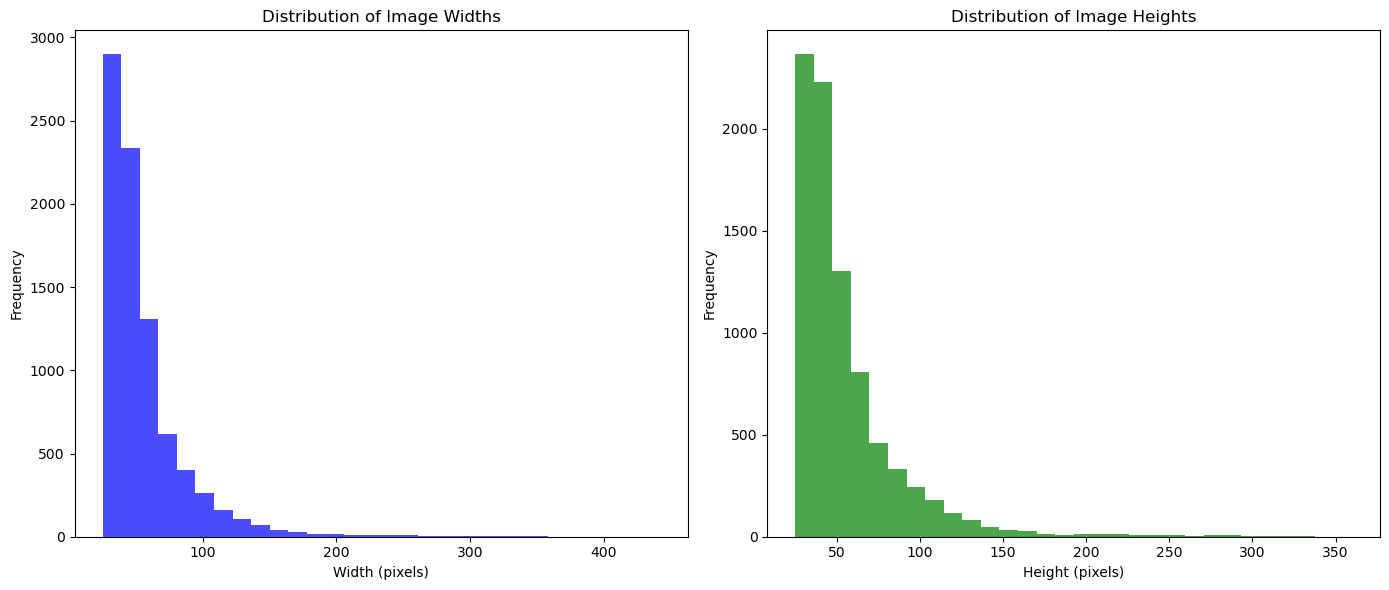

In [16]:
# Plot pixel size distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(df['width'], bins=30, color='blue', alpha=0.7)
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Widths')

plt.subplot(1, 2, 2)
plt.hist(df['height'], bins=30, color='green', alpha=0.7)
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights')

plt.tight_layout()
plt.show()

## New EDA. 5）Aspect Ratio Distribution

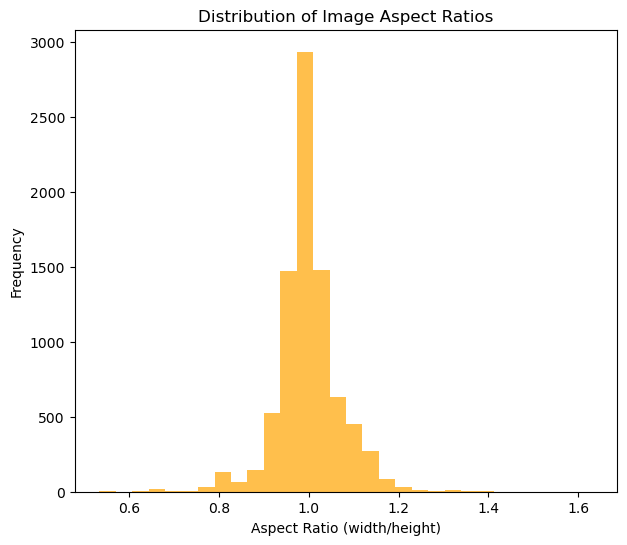

In [17]:
# Plot aspect ratio distribution
plt.figure(figsize=(7, 6))
plt.hist(df['aspect_ratio'], bins=30, color='orange', alpha=0.7)
plt.xlabel('Aspect Ratio (width/height)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Aspect Ratios')
plt.show()

## New EDA. 6） Sample Images

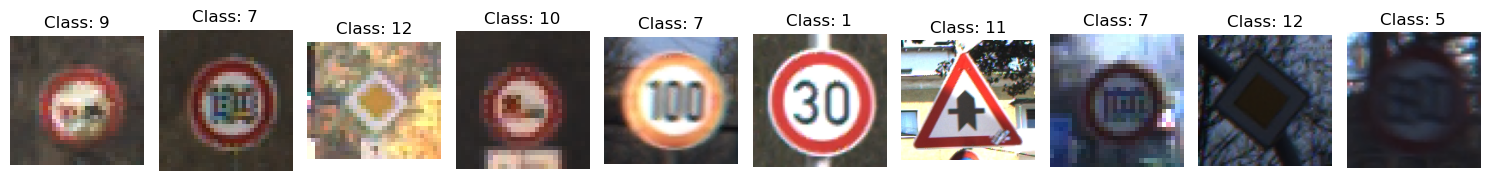

In [18]:
train_folder_path = 'train'
num_images_total = 10
all_images = []


for class_folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, class_folder)
    if os.path.isdir(folder_path): 

        image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        all_images.extend([(class_folder, img) for img in image_files])

random_images = random.sample(all_images, min(num_images_total, len(all_images)))

fig, axs = plt.subplots(1, len(random_images), figsize=(15, 5))

if num_images_total == 1:
    axs = [axs]

for idx, (class_name, img_path) in enumerate(random_images):
    img = Image.open(img_path)
    axs[idx].imshow(img)
    axs[idx].axis('off')  # Hide the axis
    axs[idx].set_title(f"Class: {class_name}")

plt.tight_layout()
plt.show()

## *Even with added new unique images in each class, the dataset is still imbalanced, to address this issue, new images are created using augumentation, but to ensure the dataset have enough data variety, upto 3 augumented images will be created using each unique image*

## 4. 2）Create Train Valid and Test using new dataset

In [19]:
# Define the paths to the directories
train_folder_path = 'Train'
valid_folder_path = 'valid'
test_folder_path = 'test'

# Create validation and test folders if they don't exist
os.makedirs(valid_folder_path, exist_ok=True)
os.makedirs(test_folder_path, exist_ok=True)

# Define the classes to keep
classes_to_keep = set(str(i) for i in range(15))

# Gather all file paths and their corresponding class labels
file_paths = []
labels = []

for class_folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, class_folder)
    if os.path.isdir(folder_path) and class_folder in classes_to_keep:
        for file_name in os.listdir(folder_path):
            file_paths.append(os.path.join(folder_path, file_name))
            labels.append(class_folder)

# Convert to numpy arrays for easier indexing
file_paths = np.array(file_paths)
labels = np.array(labels)

### Train, Val, Test split

In [20]:
# Split into training and validation sets (80% train, 20% validation)
train_files, valid_files, train_labels, valid_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

In [21]:
# Split validation set into validation and test sets (50% validation, 50% test)
valid_files, test_files, valid_labels, test_labels = train_test_split(valid_files, valid_labels, test_size=0.5, stratify=valid_labels, random_state=42)


In [22]:
# Helper function to move files to their respective directories
def move_files(file_paths, labels, target_dir):
    for file_path, label in zip(file_paths, labels):
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.move(file_path, os.path.join(label_dir, os.path.basename(file_path)))

# Move files to training, validation, and test directories
move_files(train_files, train_labels, train_folder_path)
move_files(valid_files, valid_labels, valid_folder_path)
move_files(test_files, test_labels, test_folder_path)

print("Successfully split the data into training, validation, and test sets.")


Successfully split the data into training, validation, and test sets.


## 4. 3）Balance Train set

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_folder_path = 'Train'
# Define the path to the balanced training folder
balanced_train_folder_path = 'balanced_train'

# Create balanced training folder if it doesn't exist
os.makedirs(balanced_train_folder_path, exist_ok=True)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Define a function to balance the training data
def balance_training_data(train_folder_path, balanced_train_folder_path, target_size=(64, 64), batch_size=32):
    for class_folder in os.listdir(train_folder_path):
        folder_path = os.path.join(train_folder_path, class_folder)
        if os.path.isdir(folder_path):
            image_files = os.listdir(folder_path)
            num_images = len(image_files)
            
            # Calculate the number of images needed to balance the class
            max_images = max(len(os.listdir(os.path.join(train_folder_path, cls))) for cls in os.listdir(train_folder_path))
            num_augmented_images = max_images - num_images
            
            # Create a new folder for the balanced training data
            balanced_class_folder = os.path.join(balanced_train_folder_path, class_folder)
            os.makedirs(balanced_class_folder, exist_ok=True)
            
            # Copy original images to the balanced training folder
            for image_file in image_files:
                shutil.copy(os.path.join(folder_path, image_file), os.path.join(balanced_class_folder, image_file))
            
            # Generate augmented images to balance the class
            if num_augmented_images > 0:
                image_generator = datagen.flow_from_directory(
                    train_folder_path,
                    classes=[class_folder],
                    target_size=target_size,
                    batch_size=1,
                    save_to_dir=balanced_class_folder,
                    save_prefix='aug',
                    save_format='png'
                )
                
                for _ in range(num_augmented_images):
                    next(image_generator)
                    
# Balance the training data
balance_training_data(train_folder_path, balanced_train_folder_path)

print("Balanced the training data with data augmentation.")


Found 154 images belonging to 1 classes.
Found 578 images belonging to 1 classes.
Found 576 images belonging to 1 classes.
Found 576 images belonging to 1 classes.
Found 576 images belonging to 1 classes.
Found 576 images belonging to 1 classes.
Found 381 images belonging to 1 classes.
Found 425 images belonging to 1 classes.
Found 360 images belonging to 1 classes.
Found 291 images belonging to 1 classes.
Found 262 images belonging to 1 classes.
Found 402 images belonging to 1 classes.
Found 375 images belonging to 1 classes.
Found 532 images belonging to 1 classes.
Balanced the training data with data augmentation.


## 4. 4）Balance Test set

In [24]:
test_folder_path = 'Test'
# Define the path to the balanced test folder
balanced_test_folder_path = 'balanced_test'

# Create balanced test folder if it doesn't exist
os.makedirs(balanced_test_folder_path, exist_ok=True)

# Define a function to balance the test data
def balance_test_data(test_folder_path, balanced_test_folder_path):
    for class_folder in os.listdir(test_folder_path):
        folder_path = os.path.join(test_folder_path, class_folder)
        if os.path.isdir(folder_path):
            image_files = os.listdir(folder_path)
            num_images = len(image_files)
            
            # Calculate the number of images needed to balance the class
            max_images = max(len(os.listdir(os.path.join(test_folder_path, cls))) for cls in os.listdir(test_folder_path))
            num_copied_images = max_images - num_images
            
            # Create a new folder for the balanced test data
            balanced_class_folder = os.path.join(balanced_test_folder_path, class_folder)
            os.makedirs(balanced_class_folder, exist_ok=True)
            
            # Copy original images to the balanced test folder
            for image_file in image_files:
                shutil.copy(os.path.join(folder_path, image_file), os.path.join(balanced_class_folder, image_file))
            
            # Copy additional images to balance the class
            if num_copied_images > 0:
                for i in range(num_copied_images):
                    src_file = os.path.join(folder_path, image_files[i % num_images])
                    dest_file = os.path.join(balanced_class_folder, f"copy_{i}_{os.path.basename(src_file)}")
                    shutil.copy(src_file, dest_file)

# Balance the test data
balance_test_data(test_folder_path, balanced_test_folder_path)

print("Balanced the test data by copying images.")


Balanced the test data by copying images.


## 4. 5）Visualize each class to make sure size of classes is equal

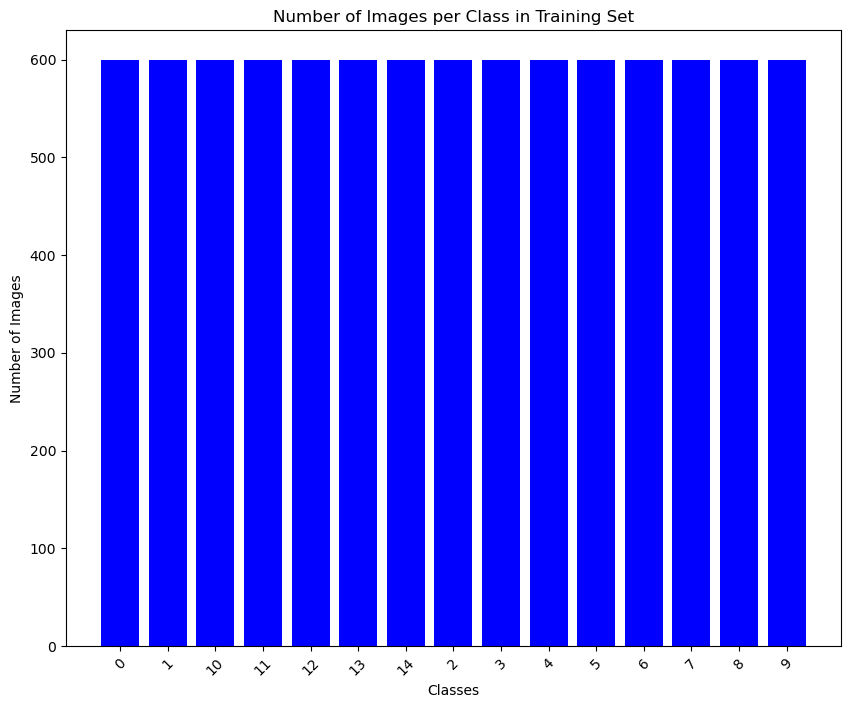

In [25]:
train_folder_path = 'balanced_train'


class_counts = {}

# Loop through each folder in the train directory
for class_folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, class_folder)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        # Count the number of image files in the directory
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        class_counts[class_folder] = num_files

# Create a sorted list of (class_name, count) pairs, sorted by the count
sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1])

# Unpack sorted pairs into separate lists
sorted_classes, sorted_counts = zip(*sorted_class_counts)

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.bar(sorted_classes, sorted_counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.xticks(rotation=45)  # Rotate class labels for better readability if needed
plt.show()


## 4. 6）Create Validation_datagen

In [26]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    'valid', 
    target_size=(64, 64), 
    batch_size=32,
    class_mode='categorical'  
)


Found 833 images belonging to 15 classes.


## 4. 7）create train_datagen

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
)

In [28]:
train_generator = train_datagen.flow_from_directory(
    'balanced_train',
    target_size=(64, 64),
    class_mode='categorical', 
    batch_size=32)

Found 9000 images belonging to 15 classes.


## 4. 8) Create Test_datagen

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test data generator
test_generator = test_datagen.flow_from_directory(
    directory='balanced_test',
    target_size=(64, 64),  # Resize images as needed
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False  # Do not shuffle for test data
)


Found 1125 images belonging to 15 classes.


# 5. Develop at a deep learning model, in this case an CNN

## 5. 1）Initial Classifier Build

In [30]:
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    
    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Fourth convolutional layer
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Flattening the results to feed into a dense layer
    Flatten(),
    
    # Dense layer
    Dense(1024, activation='relu'),
    Dropout(0.5),  # Dropout for regularization
    
    # Output layer
    Dense(15, activation='softmax') 
])

C:\Users\herry\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,453,391 (5.54 MB)

 Trainable params: 1,453,391 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

## 5. 2）Implement early stopping

In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## 5. 3）Train initial model

In [34]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20


C:\Users\herry\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


282/282 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.2357 - loss: 2.3020 - val_accuracy: 0.6699 - val_loss: 0.9158
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6509 - loss: 0.9831 - val_accuracy: 0.9052 - val_loss: 0.3142
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.8391 - loss: 0.4583 - val_accuracy: 0.9640 - val_loss: 0.1178
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9229 - loss: 0.2355 - val_accuracy: 0.9664 - val_loss: 0.1010
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9480 - loss: 0.1536 - val_accuracy: 0.9844 - val_loss: 0.0496
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9610 - loss: 0.1225 - val_accuracy: 0.9856 - val_loss: 0.0398
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9720 - loss: 0.0908 - val_accuracy: 0.9844 - val_loss: 0.0439
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9782 - loss: 0.0644 - val_accura

## 5. 4）checks for overfitting/underfitting

### Train, Val loss

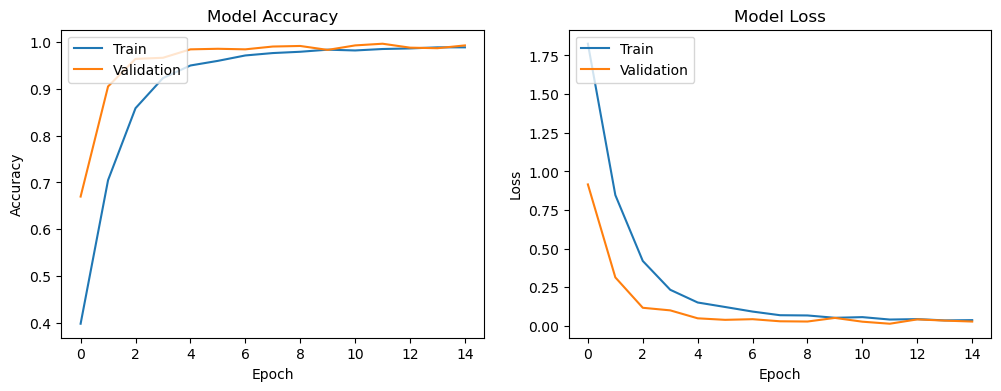

In [35]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### *There is significant sign of overfitting, so next is to increase the dropout rate and change an optimizer to see if overfit can be reduced*

## 5. 5）Second model to reduce overfitting
 - **Use only three Conv Layer**
 - **Droput rate is increased and SGD with learning rate of 0.01 and momentum of 0.9 is used instead of Adam**

In [47]:
model2 = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    
    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flattening the results to feed into a dense layer
    Flatten(),
    
    # Dense layer
    Dense(1024, activation='relu'),
    Dropout(0.7),  # Dropout for regularization
    
    # Output layer
    Dense(15, activation='softmax') 
])

C:\Users\herry\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model2.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 15)             │        15,375 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,239 (18.42 MB)

 Trainable params: 4,828,239 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [51]:
history_2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.1605 - loss: 2.5528 - val_accuracy: 0.5738 - val_loss: 1.3645
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.4917 - loss: 1.5692 - val_accuracy: 0.7011 - val_loss: 0.8898
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.5905 - loss: 1.2330 - val_accuracy: 0.7863 - val_loss: 0.6143
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6762 - loss: 0.9652 - val_accuracy: 0.8872 - val_loss: 0.3926
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.7563 - loss: 0.7462 - val_accuracy: 0.9340 - val_loss: 0.2285
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8158 - loss: 0.5487 - val_accuracy: 0.9568 - val_loss: 0.1597
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8601 - loss: 0.4398 - val_accuracy: 0.9628 - val_loss: 0.1173
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8779 - loss: 0.3719 - 

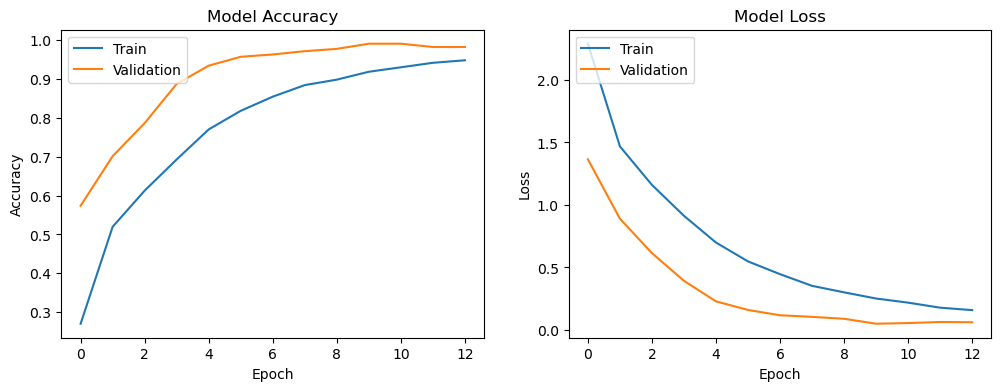

In [52]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#### *Early stop kickin at Epoch 13 and from the train, valid loss graph, there is no sign of overfitting*

## There seems no indication of overfitting becasue the train loss and valid loss did not across each other

## Next step is to predict on the test set to see how the model performed

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9873 - loss: 0.0442


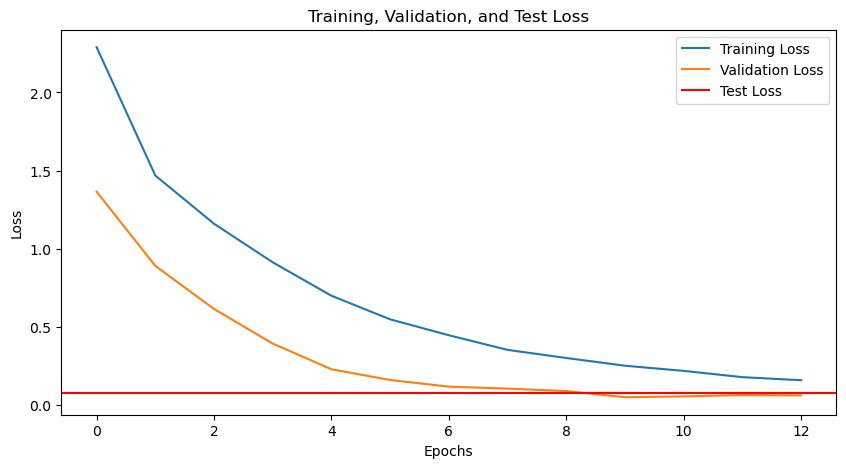

In [53]:
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

# Evaluate the model on the test set to get the test loss
test_loss, test_acc = model.evaluate(test_generator)

# Plot the training, validation, and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Adding a horizontal line for test loss
plt.axhline(y=test_loss, color='r', linestyle='-', label='Test Loss')

plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Make actual prediciton and plot an heatmap to see prediction result on each class

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


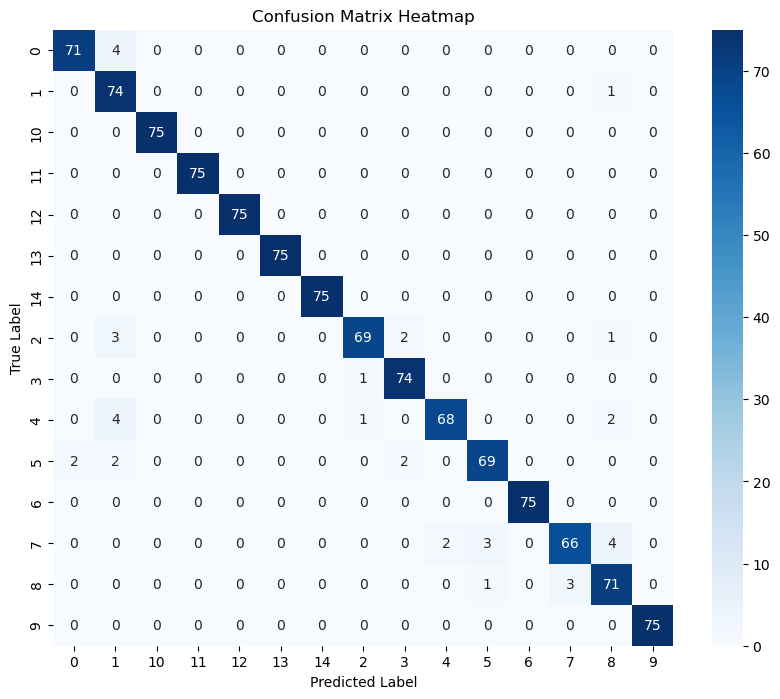

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        75
           1       0.85      0.99      0.91        75
          10       1.00      1.00      1.00        75
          11       1.00      1.00      1.00        75
          12       1.00      1.00      1.00        75
          13       1.00      1.00      1.00        75
          14       1.00      1.00      1.00        75
           2       0.97      0.92      0.95        75
           3       0.95      0.99      0.97        75
           4       0.97      0.91      0.94        75
           5       0.95      0.92      0.93        75
           6       1.00      1.00      1.00        75
           7       0.96      0.88      0.92        75
           8       0.90      0.95      0.92        75
           9       1.00      1.00      1.00        75

    accuracy                           0.97      1125
   macro avg       0.97      0.97      0.97      1125
weighted avg       0.97   

In [54]:
y_pred = model2.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


### *The prediction result seems pretty good. An accuracy score of 0.97 is achieved using a CNN model with three convolutional layers plus early stopping. The heatmap and classification report shows low precision scores for classes 1 and 8. Both classes are speed signs (class 1 is speed limit sign of 30 and class 8 is speed limit sign of 120). This might be because the dataset has many classes that are similar to class 1 and class 8 (class 0 to class 8 are all speed signs of different speed limits). In addition, Class 1, 2, 4, 5, 7, and 8 have a lower recall score compared to other classes, this might be due to the same reason why classes 1 and 8 have lower precision scores than other classes because there are a lot of class with similar features.*
### *To address this issue, we could fine-tune the CNN model (maybe add back a layer, and do more hyperparameter tuning) to get a higher accuracy score. (But in this case, a score of 0.97 is very high)*

# Furture Work

### Some Furture Work includes
#### Real-Time Sign Detection Using OpenCV
#### Real-Time Sign Detection Using YOLO

#### This CNN model can be utilized in a vehicle driving assistant system, similar to those used by companies like Tesla, which heavily rely on image classification to enhance driving safety and automation..